In [120]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
#in practice do not supress these warnings, they carry important information about the status of the model
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [127]:
# Define the ticker symbol and data retrieval
tickerSymbol = 'AAPL'
data = yf.Ticker(tickerSymbol)
prices = data.history(start='2024-01-01', end='2024-12-01').Close

# Set the ARIMA model order and window size of data taken to feed the ARMA model
order = (1, 1, 0)
window_size = 60

# List to store the forecasts
forecasts = []

In [128]:
# Calculate daily returns
returns = prices.pct_change().dropna()

# Plot the Price History

Text(0, 0.5, 'Prices')

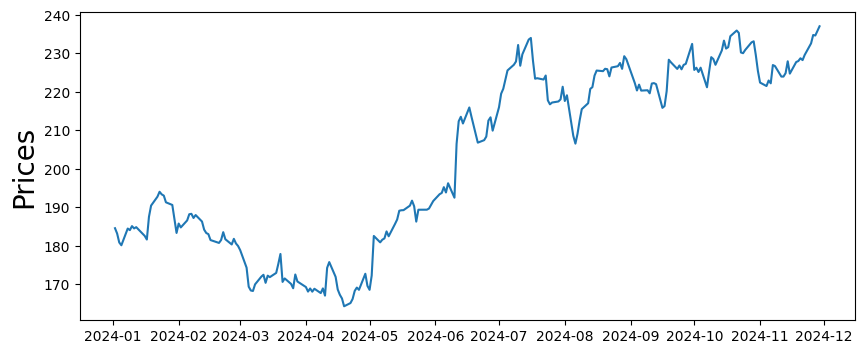

In [130]:
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.ylabel('Prices', fontsize=20)

# Plot the Returns History

Text(0, 0.5, 'Return')

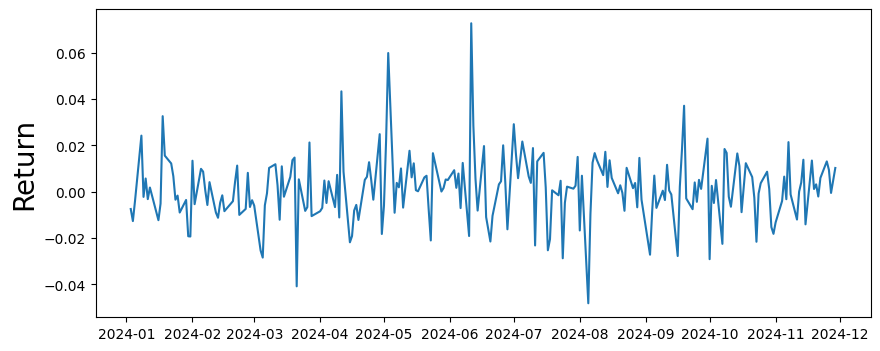

In [131]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Return', fontsize=20)

# Dickey Fuller Test to check stationarity

In [132]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(returns)
print(f"ADF test p-value: {adf_test[1]}")

ADF test p-value: 1.3521255519163688e-26


# Autocorrelation and Partial Autocorrelaction

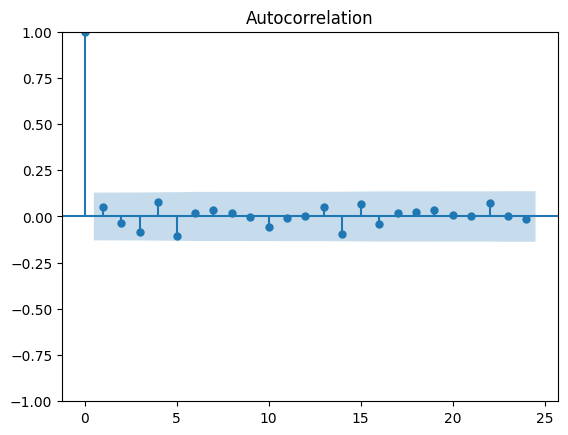

In [133]:
plot_acf(returns)
plt.show()

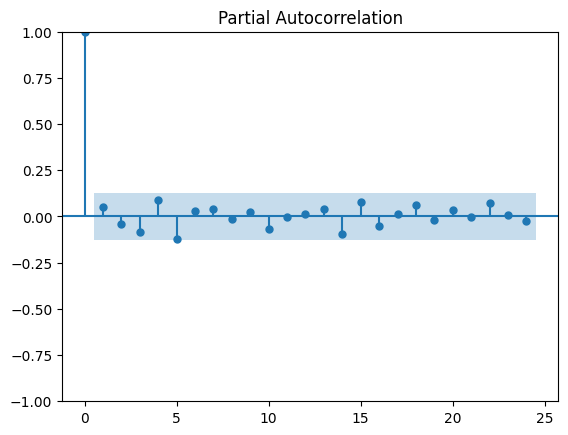

In [134]:
plot_pacf(returns)
plt.show()

In [135]:
# Remove the time component while keeping the datetime64[ns] dtype
returns.index = pd.to_datetime(returns.index.date).dropna()

# Set the frequency of the datetime index explicitly to 'B' (Business Day frequency)
returns = returns.asfreq('B')

# Roll forward ARIMA (p,q,d) forecasts

In [112]:
# Rolling window forecast loop
for i in range(window_size, len(returns)):
    # Train data using the rolling window
    train_data = returns[i - window_size:i]
    
    # Fit the ARIMA model
    model = sm.tsa.arima.ARIMA(train_data, order=order)
    model_fit = model.fit()
    
    # Forecast returns as a scalar
    forecast = model_fit.forecast()[0]
    
    forecasts.append(forecast)

# For some predictions the model is having trouble fitting the data.
#This is a common issue in time series modeling, and it can be caused by various factors like:

# - Overfitting the model (i.e., using too many parameters).
# - Data quality issues (e.g., non-stationarity or extreme outliers).
# - Too short or too noisy a dataset.


/opt/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarni

In [113]:
#Re-establish the index for the trading backtesting model

returns = returns.dropna()
returns.index = prices.index[:len(returns)].dropna()

In [114]:
def run_simulation(returns, prices, amt, order, thresh, verbose=True, plot=True):
    curr_holding = False
    events_list = []
    init_amt = amt
    
    # Go through the forecasted returns
    for idx, pred in enumerate(forecasts):
        date = returns.index[idx]  # Get the corresponding date
        
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding = False
            ret = (sell_price - buy_price) / buy_price
            amt *= (1 + ret)
            events_list.append(('s', date, ret))
            
            if verbose:
                print(f'Sold at $ {sell_price}')
                print('=======================================')
            continue

        # If not holding and forecasted return exceeds threshold, buy stock
        if (not curr_holding) and pred > thresh:
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print(f'Bought at $ {buy_price}')

    # Final output
    print(f'Total Amount: $ {round(amt, 2)}')
    
    # Plotting (same as before)
    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(prices)
        y_lims = (int(prices.min() * 0.95), int(prices.max() * 1.05))
        shaded_y_lims = int(prices.min() * 0.5), int(prices.max() * 1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims),
                                  event[1], events_list[idx - 1][1], color=color, alpha=0.1)

        tot_return = round(100 * (amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title(f"{tickerSymbol} Price Data\nThresh={thresh}\nTotal Amt: $ {round(amt, 2)}\nTotal Return: {tot_return}", fontsize=20)
        plt.ylim(*y_lims)
        plt.show()

    return amt

## Run the model for different thrsholds

Bought at $ 183.15037536621094
Sold at $ 180.82435607910156
Bought at $ 184.81040954589844
Sold at $ 182.53408813476562
Bought at $ 190.41676330566406
Sold at $ 192.7328338623047
Bought at $ 183.29946899414062
Sold at $ 185.7448272705078
Bought at $ 184.74082946777344
Sold at $ 186.55990600585938
Bought at $ 188.17025756835938
Sold at $ 188.27960205078125
Bought at $ 187.96249389648438
Sold at $ 186.2704620361328
Bought at $ 184.17034912109375
Sold at $ 183.2845458984375
Bought at $ 182.99591064453125
Sold at $ 181.4532012939453
Bought at $ 180.70672607421875
Sold at $ 181.4631805419922
Bought at $ 183.5035400390625
Sold at $ 181.66224670410156
Bought at $ 180.30860900878906
Sold at $ 181.77171325683594
Bought at $ 180.56739807128906
Sold at $ 179.90054321289062
Bought at $ 168.32518005371094
Sold at $ 168.20574951171875
Bought at $ 169.92762756347656
Sold at $ 171.93812561035156
Bought at $ 172.41586303710938
Sold at $ 170.3257598876953
Bought at $ 172.18695068359375
Sold at $ 171.808

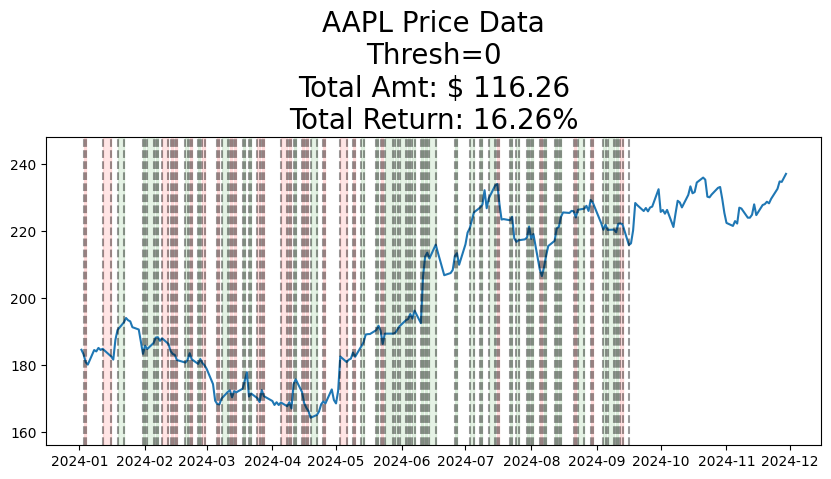

Bought at $ 183.15037536621094
Sold at $ 180.82435607910156
Bought at $ 190.41676330566406
Sold at $ 192.7328338623047
Bought at $ 183.29946899414062
Sold at $ 185.7448272705078
Bought at $ 184.74082946777344
Sold at $ 186.55990600585938
Bought at $ 188.17025756835938
Sold at $ 188.27960205078125
Bought at $ 187.96249389648438
Sold at $ 186.2704620361328
Bought at $ 184.17034912109375
Sold at $ 183.2845458984375
Bought at $ 182.99591064453125
Sold at $ 181.4532012939453
Bought at $ 181.4631805419922
Sold at $ 183.5035400390625
Bought at $ 181.66224670410156
Sold at $ 180.30860900878906
Bought at $ 180.56739807128906
Sold at $ 179.90054321289062
Bought at $ 168.32518005371094
Sold at $ 168.20574951171875
Bought at $ 171.93812561035156
Sold at $ 172.41586303710938
Bought at $ 170.3257598876953
Sold at $ 172.18695068359375
Bought at $ 171.80874633789062
Sold at $ 172.90357971191406
Bought at $ 175.2524871826172
Sold at $ 177.83030700683594
Bought at $ 170.5646209716797
Sold at $ 171.47035

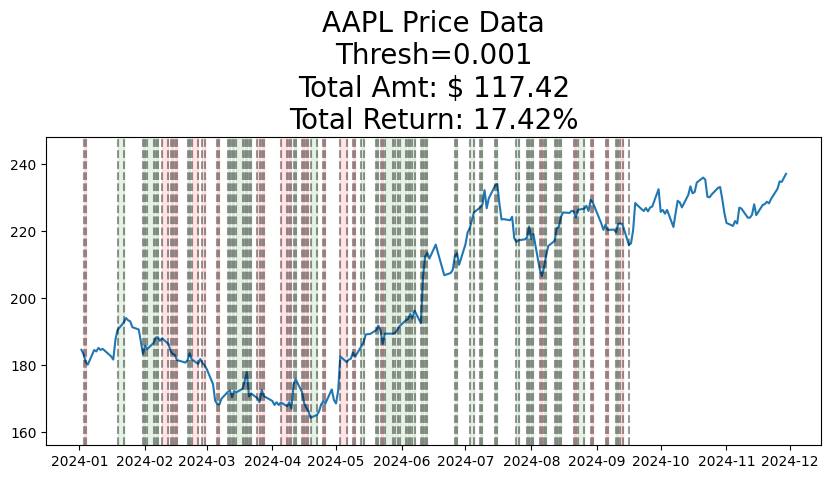

Bought at $ 183.15037536621094
Sold at $ 180.82435607910156
Bought at $ 190.41676330566406
Sold at $ 192.7328338623047
Bought at $ 183.29946899414062
Sold at $ 185.7448272705078
Bought at $ 184.74082946777344
Sold at $ 186.55990600585938
Bought at $ 188.17025756835938
Sold at $ 188.27960205078125
Bought at $ 187.96249389648438
Sold at $ 186.2704620361328
Bought at $ 184.17034912109375
Sold at $ 183.2845458984375
Bought at $ 181.4532012939453
Sold at $ 180.70672607421875
Bought at $ 181.4631805419922
Sold at $ 183.5035400390625
Bought at $ 181.66224670410156
Sold at $ 180.30860900878906
Bought at $ 179.90054321289062
Sold at $ 178.815673828125
Bought at $ 168.32518005371094
Sold at $ 168.20574951171875
Bought at $ 172.41586303710938
Sold at $ 170.3257598876953
Bought at $ 172.18695068359375
Sold at $ 171.80874633789062
Bought at $ 170.5646209716797
Sold at $ 171.47035217285156
Bought at $ 170.0470733642578
Sold at $ 168.9124298095703
Bought at $ 172.49549865722656
Sold at $ 170.67410278

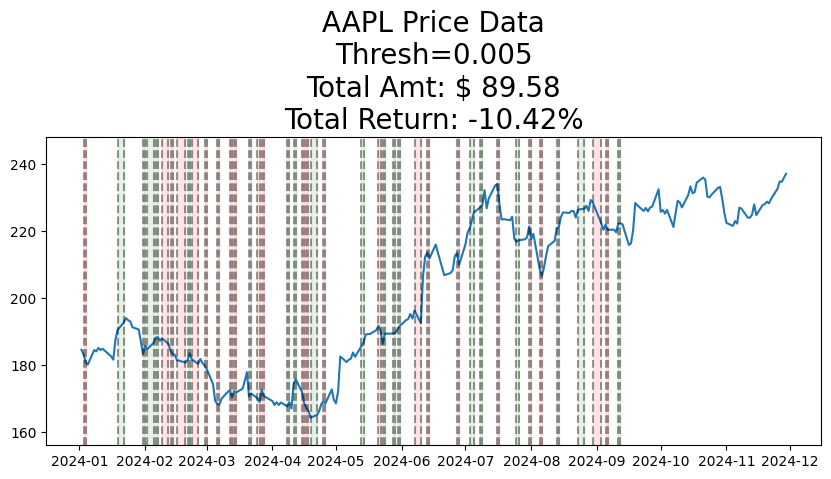

In [116]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (1,0,0), thresh, verbose=True)